# Step 1 - Select S&P500 Dataset and Schiller P/E-10 Dataset from the URLs

In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from skimage import color
from skimage.transform import rescale, resize,downscale_local_mean

import matplotlib.pyplot as plt
print("Data of S&P 500")
dataframe = pd.read_csv("HistoricalData_1648610849582.csv")
print(dataframe)
print("Data of PE Ration")
data_pe = pd.read_csv('S&P500 Schiller PE ratio.csv')
print(data_pe)
test=False

Data of S&P 500
            Date  Close/Last Volume     Open     High      Low
0     03/28/2022     4575.52     --  4541.09  4575.65  4517.69
1     03/25/2022     4543.06     --  4522.91  4546.03  4501.07
2     03/24/2022     4520.16     --  4469.98  4520.58  4465.17
3     03/23/2022     4456.24     --  4493.10  4501.07  4455.81
4     03/22/2022     4511.61     --  4469.10  4522.00  4469.10
...          ...         ...    ...      ...      ...      ...
2545  04/05/2012     1398.08     --  1398.79  1401.60  1392.92
2546  04/04/2012     1398.96     --  1413.09  1413.09  1394.09
2547  04/03/2012     1413.38     --  1418.98  1419.00  1404.62
2548  04/02/2012     1419.04     --  1408.47  1422.38  1404.46
2549  03/30/2012     1408.47     --  1403.31  1410.89  1401.42

[2550 rows x 6 columns]
Data of PE Ration
                 DateTime  SP500PERatio
0     1871-01-01 00:00:58         11.10
1     1871-02-01 00:00:58         11.25
2     1871-03-01 00:00:58         11.52
3     1871-04-01 00:00:58

# Step 2 - Develop and test/verify a correlation-based algorithm

In [2]:
date_pe = data_pe[["DateTime"]].to_numpy(dtype = "str")
date_sp = dataframe[["Date"]].to_numpy(dtype = "str")

date_pe = np.flip(date_pe)
date_sp = np.flip(date_sp)


ratio_sp = data_pe['SP500PERatio'].to_numpy(dtype = 'float')
mean_sp = ratio_sp.mean()
max_sp = ratio_sp.max()
median_sp = np.median(ratio_sp)
print(mean_sp)
print(max_sp)
print(median_sp)

sp_index = dataframe[["Close/Last", "Open"]].to_numpy(dtype = 'float')
mean_sp_index = sp_index[:,0].mean()
mean_sp_index1 = sp_index[:,1].mean()

print(mean_sp_index)
print(mean_sp_index1)

16.126808278867102
123.73
14.955
2535.1493960784314
2510.4491058823533


In [3]:
#Merge the data of S$P500 and PE ration
record = []
recordDate = []

# get the date from data
def get_date(date_data):
    res = (date_data[:-5]).split('/')
    if(len(res)==3):
        return res
    return None

array_date_pe = date_pe.tolist()

# if the S&P and PE in the same year and month, merge it into an item.

for i in range(len(date_sp)):
    tmp = [0 for _ in range(3)]
    tmp[0] = sp_index[i][0]
    record_time = str(date_sp[i][0])
    for j in range(len(ratio_sp)):
        peDate = get_date( array_date_pe[j][0] )

        if(peDate is not None and len(peDate)==3) :
            if(record_time[6:10]==peDate[2] ):
                    if(peDate[1]==record_time[0:2] or ('0'+peDate[1])==record_time[0:2]):
                        tmp[1] = ratio_sp[j]
                        recordDate.append(record_time)
                        record.append(tmp)

dataset = np.array(record)
    

In [4]:
# Calculate the correlation scores

sampleNum = 100
for i in range(sampleNum-1 ,len(dataset)):
    # Pearson  r
    x = dataset[(i-sampleNum+1):(i+1), 0]
    y = dataset[(i-sampleNum+1):(i+1), 1]
    r = np.corrcoef(x, y)
    dataset[i][2] = r[0,1] 
dataset

array([[ 4.57552000e+03,  1.40600000e+01,  0.00000000e+00],
       [ 4.54306000e+03,  1.44300000e+01,  0.00000000e+00],
       [ 4.52016000e+03,  1.44300000e+01,  0.00000000e+00],
       ...,
       [ 1.41338000e+03,  1.11000000e+01, -2.93913436e-01],
       [ 1.41904000e+03,  1.11000000e+01, -3.36308416e-01],
       [ 1.40847000e+03,  1.11000000e+01, -3.74877898e-01]])

Text(0, 0.5, 'Correlation')

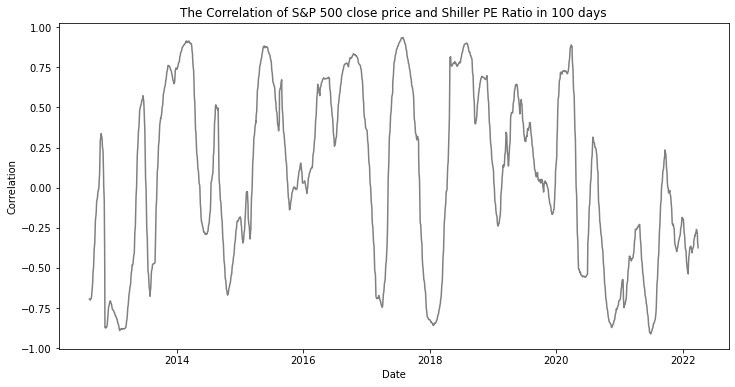

In [5]:
dateDigital = [];

for i in range(len(recordDate)):
    dateDigital.append(float(recordDate[i][6:10]) + ( (float(recordDate[i][0:2])-1)*30 + float(recordDate[i][3:5]) )/366 )

plt.figure(figsize=(12, 6));
plt.plot(dateDigital[(sampleNum-1):],
         dataset[(sampleNum-1):, 2], color='grey', label='Close')
plt.title('The Correlation of S&P 500 close price and Shiller PE Ratio in 100 days')
plt.xlabel('Date')
plt.ylabel('Correlation')

In [6]:
# Buy the sp when r>threshold
money = 1
money_all = []
trade_all = []
# Must buy the new stock before sell
lastsell=0

for i in range(sampleNum-1, dataset.shape[0]):
    corr_temp = dataset[i,2]
    price_temp = dataset[(i-sampleNum+1):(i+1), 0]
    if corr_temp > 0.5 and (i-lastsell > sampleNum):
        # sell at this point
        # buy at the local minia in this window interval (nsample interval)
        buy_price = min(price_temp)
        # in case of the overflow
        if buy_price > 0:           
            sell_price = price_temp[len(price_temp)-1]
            money = sell_price/buy_price*money
            lastsell = i
            print(buy_price)
            print(sell_price)
            print(money)
            print(i)
            money_all.append(money)
            trade_all.append(i)


3714.24
3748.14
1.0091270354096666
308
3236.92
3380.35
1.05384210117861
409
2237.4
2409.39
1.1348514437108839
510
2954.22
2966.15
1.1394343040677535
618
2743.07
2744.73
1.140123845692558
787
2351.1
2888.8
1.4008718325195277
888
2581.88
2703.96
1.467109780570554
1031
2507.04
2507.04
1.467109780570554
1132
2238.83
2253.28
1.476578894495794
1329
1829.08
1880.33
1.5179519718586811
1560
1881.77
1940.51
1.565335285880575
1661
1994.99
2057.09
1.6140610044321384
1813
1888.03
1888.03
1.6140610044321384
1991


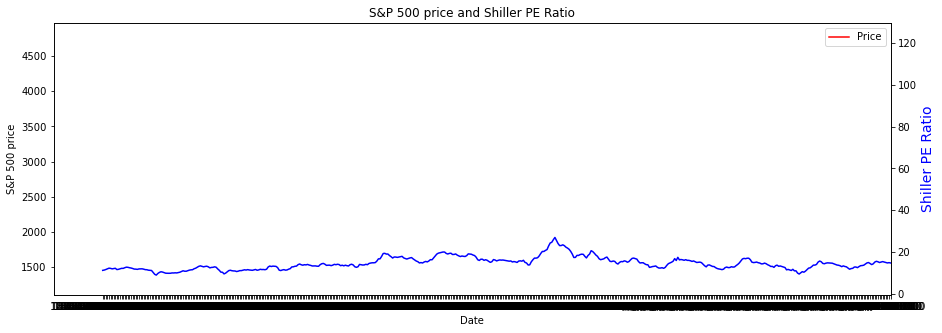

In [7]:
plt.figure(figsize=(15, 5));
#plt.plot(dataframe.Date, dataframe.Open.values, color='grey', label='Open')
# plt.plot(dataframe.Date, dataframe.Close.values, color='black', label='Close')
#plt.plot(dataframe.Date, dataframe.Low.values, color='red', label='Low')
#plt.plot(dataframe.Date, dataframe.High.values, color='green', label='High')
plt.plot(dataframe.Date, dataframe["Close/Last"].values, color = 'red', label='Price')
plt.title('S&P 500 price and Shiller PE Ratio')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
# twin object for two different y-axis on the sample plot
ax2=plt.twinx()
ax2.set_xticks(ax2.get_xticks()[::100])
plt.xlim(-31.1,500.1)
# make a plot with different y-axis using second axis object
ax2.plot(data_pe.DateTime, data_pe.SP500PERatio.values,color="blue")
ax2.set_ylabel("Shiller PE Ratio", color="blue",fontsize=14)
plt.show()

13
13


Text(0, 0.5, 'Money/millions')

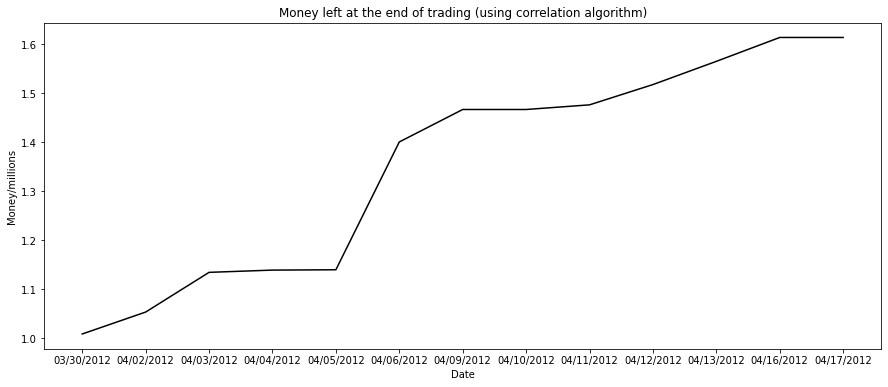

In [8]:
# Make a plot

date_trade = []
for i in range(len(trade_all)):
    date_trade.append(recordDate[i])
    
plt.figure(figsize=(15, 6))
print(len(date_trade))
print(len(money_all))
plt.plot(date_trade,
         money_all, color='black', label='Close')
plt.title('Money left at the end of trading (using correlation algorithm)')
plt.xlabel('Date')
plt.ylabel('Money/millions')

# Step 3 - Design and develop a convolutional neural network (CNN) in Python that will recognize A-B-C-D-wave patterns

In [9]:
# Judge if their exist a A-B-C-D wave, if exist, save it.
sellSigIdx = []
prev = 0
for x in range(sampleNum-1, len(dataset)):
    if dataset[x][2] > 0.5 and x >= prev+sampleNum//3 and \
    dataset[x][0] == max(dataset[(x-sampleNum+1):(x+1), 0]) and \
    dataset[x][0] > dataset[x+1][0]:
        sellSigIdx.append(x)
        prev = x
sellSigIdx

[531, 885, 1046, 1592, 1688]

In [10]:
import torch.functional as F
import pdb
class CNet(nn.Module):
    def __init__(self, linear_input=60):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=20,padding=2,padding_mode='replicate', kernel_size=5, stride=1)
        self.max_pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.ReLU = nn.ReLU()
        self.linear1 = nn.Linear(linear_input, 4)
        
    def forward(self, x):
        if(test==True):
            x = x.permute(0,2,1)
        else:
            x = x.permute(0, 2, 1) 
#         import pdb
#         pdb.set_trace()
        x = self.conv1(x)
        
        x =  self.ReLU( self.max_pool1(x) ) 
        
        x = x.view(x.size(0), -1)
        x = self.ReLU(self.linear1(x))
        x = x.unsqueeze(1)
        return x


class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.cnn = CNet()
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        
        self.fc = nn.Linear(hidden_dim, output_size)
        self.ReLU = nn.ReLU()
        
    
    def forward(self, x):
       
        x = self.cnn(x) 
        
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)

        out, hidden = self.rnn(x, hidden)
    
        out = self.fc(out)
    
        return out[:, -1, :], hidden
    
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [11]:

trainData = dataframe[["Close/Last", "Open",'High','Low']].to_numpy(dtype = 'float')
targetData = dataframe[["Close/Last"]].to_numpy(dtype = 'float')
date = dataframe[["Date"]].to_numpy(dtype = "str")

norm = MinMaxScaler(feature_range = (0, 1))
trainData = norm.fit_transform(trainData)
targetData = norm.fit_transform(targetData)
trainData = np.flip(trainData)
targetData = np.flip(targetData)
date = np.flip(date)
dateData = []
for i in range(date.shape[0]):
    dateData.append(float(np.squeeze(date)[i][6:10]) + ( (float(np.squeeze(date)[i][0:2])-1)*30 + float(np.squeeze(date)[i][3:5]) )/366 )
dateData = np.array(dateData)


In [12]:
window_size = 6
X = []
Y = []
for i in range(trainData.shape[0] - window_size - 4):
    X.append(trainData[i:i+window_size])
    Y.append(targetData[i+window_size:i+window_size+4])
X = np.array(X)
Y = np.array(Y)
Y = np.swapaxes(Y, 1, 2)
dateAxis = dateData[:-(window_size+4)]

In [13]:
X_fullTraining = []
X_training = []
X_validation = []
X_test = []
Y_fullTraining = []
Y_training = []
Y_validation = []
Y_test = []


# 20% for test

# For the left 80% data, 80% * 80% =64% for train, 80% * 20% = 16% for valdation 
X_fullTraining, X_test, Y_fullTraining, Y_test, date_ft, date_t = train_test_split(X, Y, dateAxis, test_size=0.2, shuffle=False)
X_training, X_validation, Y_training, Y_validation, date_tr, date_v = train_test_split(X_fullTraining, Y_fullTraining, date_ft, test_size=0.2, shuffle=False)
#date_test=date[438:623,:]

In [14]:
RNN = Model(input_size=4, output_size=4, hidden_dim=16, n_layers=1)
optimizer = torch.optim.Adam(RNN.parameters(), lr=0.01)
criterion = nn.MSELoss()
RNN

Model(
  (cnn): CNet(
    (conv1): Conv1d(4, 20, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=replicate)
    (max_pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (ReLU): ReLU()
    (linear1): Linear(in_features=60, out_features=4, bias=True)
  )
  (rnn): RNN(4, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
  (ReLU): ReLU()
)

In [15]:
xTensor = torch.from_numpy(X_training).float()
xTensor_val = torch.from_numpy(X_validation).float()
yTensor = torch.Tensor(Y_training).float()
yTensor_val = torch.from_numpy(Y_validation).float()
epochs  =150

record_epoch = []
record_loss = []
record_loss_val = []
for epoch in range(epochs):
    optimizer.zero_grad()
    
    output, hidden = RNN(xTensor)
    output_val, _ = RNN(xTensor_val)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    loss_val = criterion(output_val.reshape(-1), yTensor_val.view(-1))
    loss.backward()
    
    optimizer.step()
    record_epoch.append(epoch)
    record_loss.append(loss.item())
    record_loss_val.append(loss_val.item())
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, epochs), end=' ')
        print("Loss:", loss.item())

Epoch: 0/150............. Loss: 0.08445637673139572
Epoch: 10/150............. Loss: 0.011864088475704193
Epoch: 20/150............. Loss: 0.009244908578693867
Epoch: 30/150............. Loss: 0.0055022952146828175
Epoch: 40/150............. Loss: 0.001448493218049407
Epoch: 50/150............. Loss: 0.0007061383221298456
Epoch: 60/150............. Loss: 0.00018705932598095387
Epoch: 70/150............. Loss: 0.0001712738157948479
Epoch: 80/150............. Loss: 0.00012043436436215416
Epoch: 90/150............. Loss: 0.00010466692037880421
Epoch: 100/150............. Loss: 9.825191227719188e-05
Epoch: 110/150............. Loss: 9.583662176737562e-05
Epoch: 120/150............. Loss: 9.261201194021851e-05
Epoch: 130/150............. Loss: 9.071693784790114e-05
Epoch: 140/150............. Loss: 8.911522309063002e-05


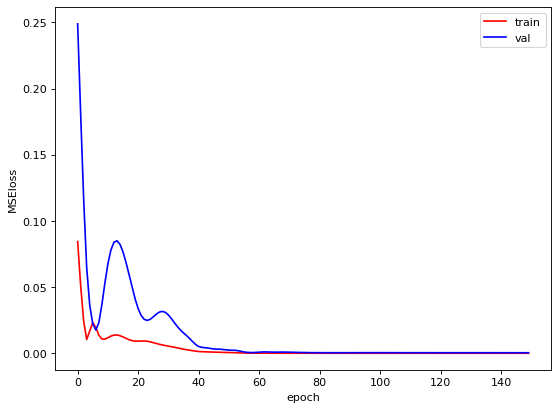

In [16]:
plt.figure(figsize=[8,6], dpi=80)
plt.plot(np.array(record_loss), 'r', label = 'train')
plt.plot(np.array(record_loss_val), 'b', label = 'val')
plt.xlabel("epoch")
plt.ylabel("MSEloss")
plt.legend()
#plt.savefig('MSEloss_1.eps')

# Step 4 - Train your CNN and RNN on your Training Set

In [17]:
def prediction_error(pred, actual):
    return abs(pred - actual)/pred

# Calculate the accuracy, make a plot
def plotGraphs(output_1,output_2,output_3,output_4,Y_main,Y_plot,XAxis_date,date_pred,
    set1_title_1,set2_title_1,set3_title_1,set4_title_1,error_title):
    
    table = []

    error = prediction_error(output_1, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp1 = np.array(temp1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set1_title_1)
    ax1.plot(date_pred, output_1, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    error = prediction_error(output_2, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp2 = np.array(temp2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set2_title_1)
    ax1.plot(date_pred, output_2, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    error = prediction_error(output_3, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp3 = np.array(temp3)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set3_title_1)
    ax1.plot(date_pred, output_3, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    error = prediction_error(output_4, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp4 = np.array(temp4)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set4_title_1)
    ax1.plot(date_pred, output_plt4, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    temp1 = np.expand_dims(temp1, axis=1)
    temp2 = np.expand_dims(temp2, axis=1)
    temp3 = np.expand_dims(temp3, axis=1)
    temp4 = np.expand_dims(temp4, axis=1)
    table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
    ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
    col = ['1 day', '2 day', '3 day', '4 day']
    stats=pd.DataFrame(table, columns=col, index=ind).T
    display(stats)


def plotAccuracy(output_1,output_2,output_3,output_4,Y_main, date_pred, title_content ):
    
    table = []

    error_1 = prediction_error(output_1, Y_main)
    error_2 = prediction_error(output_2, Y_main)
    error_3 = prediction_error(output_3, Y_main)
    error_4 = prediction_error(output_4, Y_main)
    
    fig = plt.figure(figsize=(9, 5))
    plt.title(title_content)
    plt.plot(date_pred, error_1, color = 'blue', label = 't+1')
    plt.plot(date_pred, error_2, color = 'green', label = 't+2')
    plt.plot(date_pred, error_3, color = 'purple', label = 't+3')
    plt.plot(date_pred, error_4, color = 'red', label = 't+4')
    plt.legend(loc="upper left")
    
    plt.show()



(2540, 1)
(1625, 1)
(1625, 1, 4)


,Mean,STD-dev,Skewness,Kurtosis
1 day,0.999903,0.000038,0.649337,-0.356865
2 day,0.999903,0.000038,0.636637,-0.359513
3 day,0.999903,0.000038,0.636736,-0.359710
4 day,0.999903,0.000038,0.641226,-0.361863


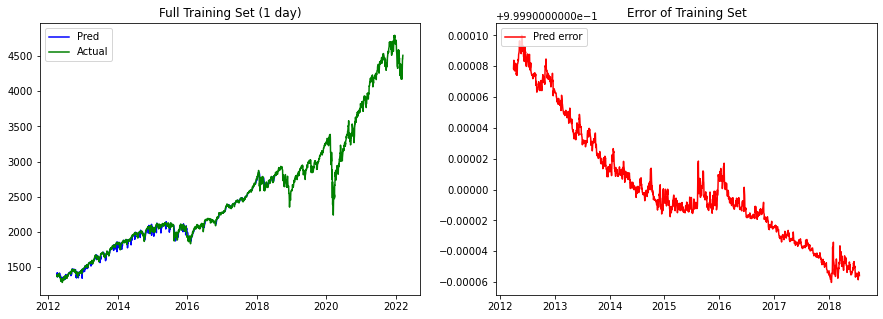

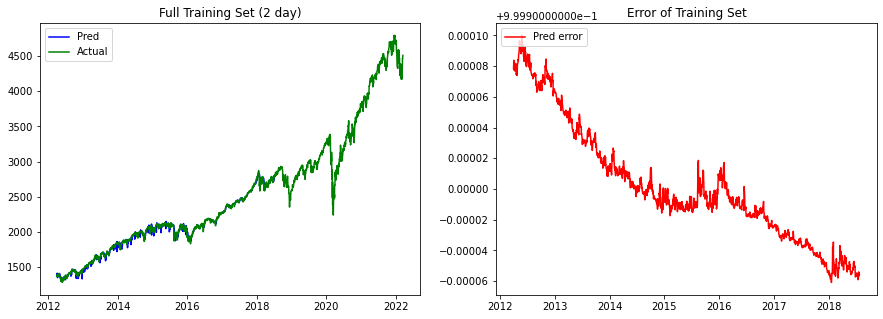

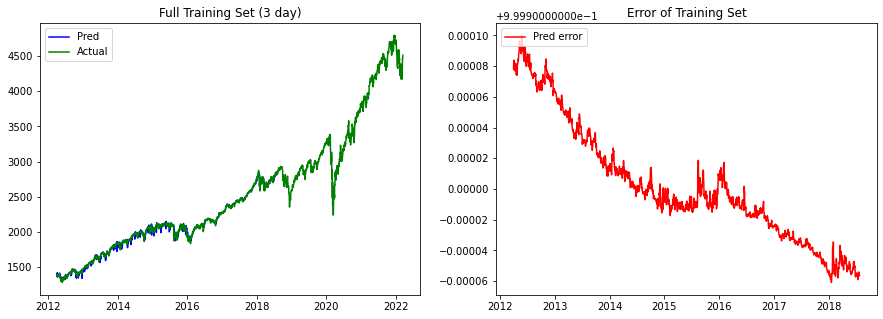

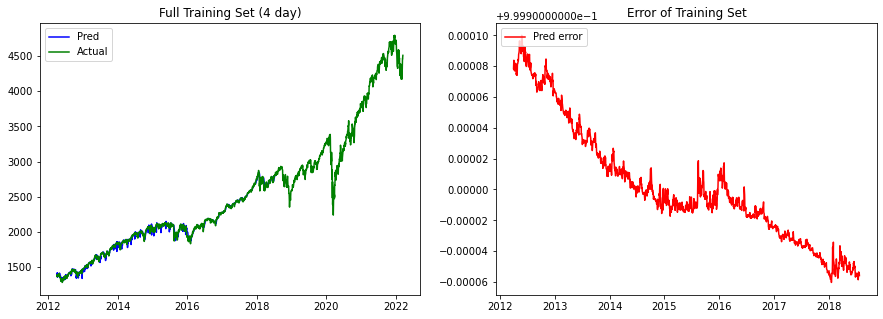

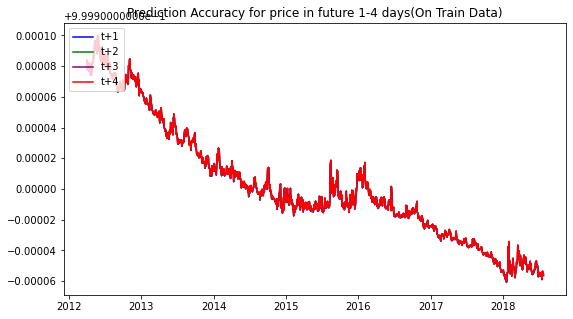

In [18]:
import pdb
#pdb.set_trace()
output_plt = output.detach().numpy()

output_plt = output_plt

Y_plt = norm.inverse_transform(Y[:, :, 0])

print(Y_plt.shape)
Y_fullTrainingplt = norm.inverse_transform(Y_fullTraining[:, :, 0])

output_plt1 = norm.inverse_transform(output_plt[:,0].reshape(-1,1))
output_plt2 = norm.inverse_transform(output_plt[:,1].reshape(-1,1))
output_plt3 = norm.inverse_transform(output_plt[:,2].reshape(-1,1))
output_plt4 = norm.inverse_transform(output_plt[:,3].reshape(-1,1))

print(output_plt1.shape)
print(Y_training.shape)
Y_output = Y_training[:,:,0]

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

#plotGraphs(output_plt1,output_plt2,output_plt3,output_plt4,Y_testplt,Y_plt,dateAxis,date_t,



#import pdb
#pdb.set_trace()

plotGraphs(output_plt1,output_plt2,output_plt3,output_plt4,Y_output,Y_plt,dateAxis,date_tr,
"Full Training Set (1 day)","Full Training Set (2 day)","Full Training Set (3 day)","Full Training Set (4 day)","Error of Training Set")

plotAccuracy(output_plt1,output_plt2,output_plt3,output_plt4,Y_output,date_tr, 'Prediction Accuracy for price in future 1-4 days(On Train Data)' )

# Step 5 - Test your CNN and RNN accuracy over Test Data

In [19]:
# Calculate the accuracy, make a plot

def prediction_error(pred, actual):
    return abs(pred - actual)/pred




,Mean,STD-dev,Skewness,Kurtosis
1 day,0.061606,0.035816,0.154470,-1.068501
2 day,0.077615,0.043883,0.062895,-1.121512
3 day,0.090350,0.052351,0.060801,-1.185588
4 day,0.056067,0.031439,0.140268,-1.003039


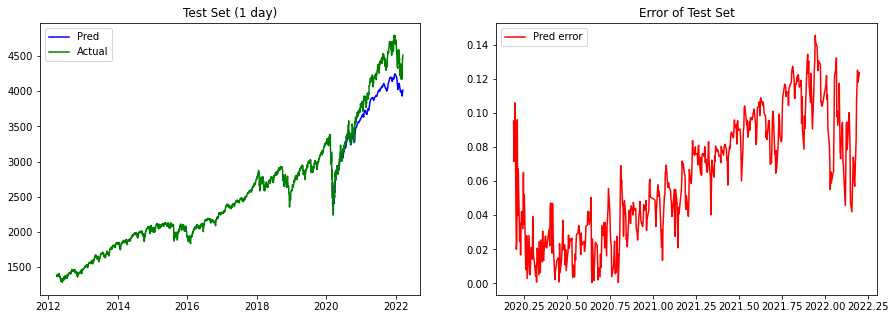

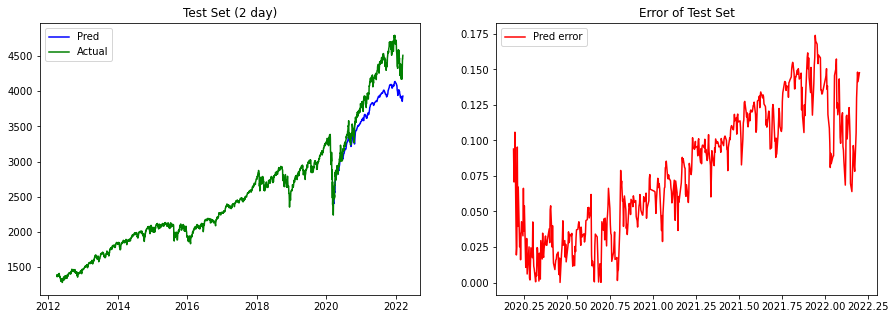

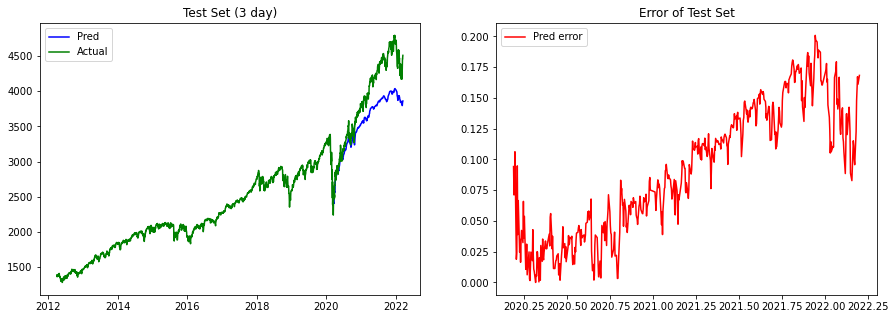

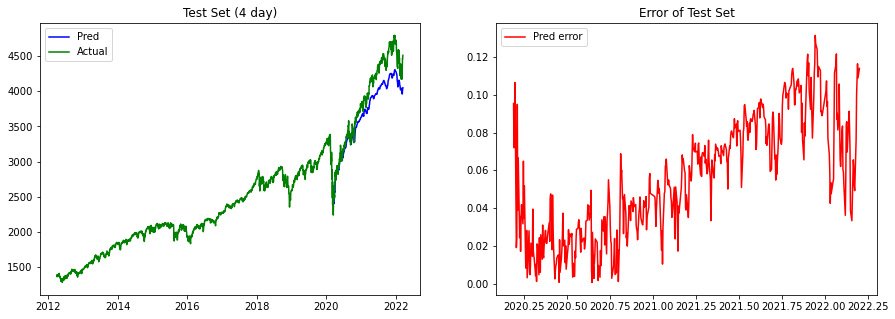

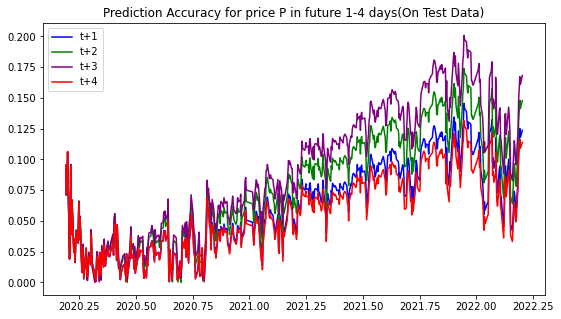

In [20]:
RNN.eval()
xTensor = torch.from_numpy(X_test).float()
output, _ = RNN(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

plotGraphs(output_plt1,output_plt2,output_plt3,output_plt4,Y_testplt,Y_plt,dateAxis,date_t,
"Test Set (1 day)","Test Set (2 day)","Test Set (3 day)","Test Set (4 day)","Error of Test Set")

plotAccuracy(output_plt1,output_plt2,output_plt3,output_plt4,Y_testplt,date_t, 'Prediction Accuracy for price P in future 1-4 days(On Test Data)' )

# Step 6 - Optimize your CNN+RNN algorithm's performance 

### Adjust the parameter of the network and enhance the sliding window size

In [21]:
input_size = 4
output_size =4
hidden_dim = 32
n_layers = 2
epochs = 200
window_size = 100


X = []
Y = []
for i in range(trainData.shape[0] - window_size - 4):
    X.append(trainData[i:i+window_size])
    Y.append(targetData[i+window_size:i+window_size+4])
X = np.array(X)
Y = np.array(Y)
Y = np.swapaxes(Y, 1, 2)
X_fullTraining = []
X_training = []
X_validation = []
X_test = []
Y_fullTraining = []
Y_training = []
Y_validation = []
Y_test = []

dateAxis = []
dateData = []
for i in range(date.shape[0]):
    dateData.append(float(np.squeeze(date)[i][6:10]) + ( (float(np.squeeze(date)[i][0:2])-1)*30 + float(np.squeeze(date)[i][3:5]) )/366 )
dateData = np.array(dateData)
dateAxis = dateData[(window_size+4):]


X_fullTraining, X_test, Y_fullTraining, Y_test, date_ft, date_t = train_test_split(X, Y, dateAxis, test_size=0.2, shuffle=False)
X_training, X_validation, Y_training, Y_validation, date_tr, date_v = train_test_split(X_fullTraining, Y_fullTraining, date_ft, test_size=0.2, shuffle=False)

In [22]:
RNN_enhance = Model(input_size, output_size, hidden_dim, n_layers)
RNN_enhance.cnn = CNet(50*20)
optimizer = torch.optim.Adam(RNN_enhance.parameters(), lr=0.001)
criterion = nn.MSELoss()
import pdb
#pdb.set_trace()
xTensor = torch.from_numpy(X_training).float()
yTensor = torch.Tensor(Y_training).float()

for epoch in range(epochs):
    optimizer.zero_grad()
    
    output, hidden = RNN_enhance(xTensor)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizer.step()
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, epochs), end=' ')
        print("Loss:", loss.item())

Epoch: 0/200............. Loss: 0.19345074892044067
Epoch: 10/200............. Loss: 0.08390512317419052
Epoch: 20/200............. Loss: 0.008163299411535263
Epoch: 30/200............. Loss: 0.012533149681985378
Epoch: 40/200............. Loss: 0.007407130673527718
Epoch: 50/200............. Loss: 0.006244956515729427
Epoch: 60/200............. Loss: 0.005479015875607729
Epoch: 70/200............. Loss: 0.004455076530575752
Epoch: 80/200............. Loss: 0.0036397366784512997
Epoch: 90/200............. Loss: 0.0027764681726694107
Epoch: 100/200............. Loss: 0.001939492765814066
Epoch: 110/200............. Loss: 0.0012313484912738204
Epoch: 120/200............. Loss: 0.0007390825776383281
Epoch: 130/200............. Loss: 0.0004937414196319878
Epoch: 140/200............. Loss: 0.00041745053022168577
Epoch: 150/200............. Loss: 0.0003966580843552947
Epoch: 160/200............. Loss: 0.00038147071609273553
Epoch: 170/200............. Loss: 0.0003689316799864173
Epoch: 180/2

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.202504,0.090148,-0.312539,-0.810826
2 day,0.188334,0.079233,-0.405076,-0.627762
3 day,0.202910,0.090916,-0.303118,-0.835209
4 day,0.212910,0.092489,-0.389034,-0.723028


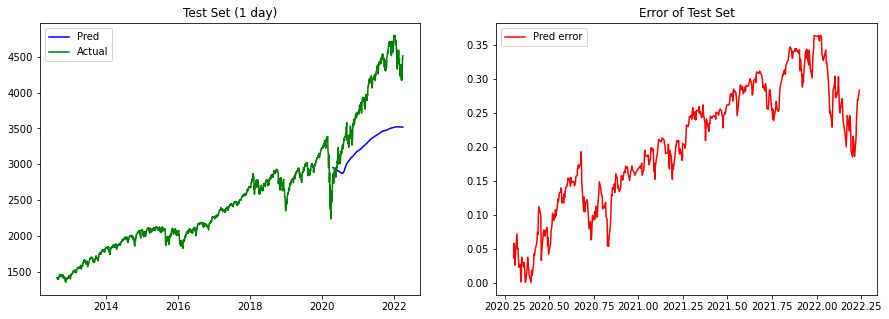

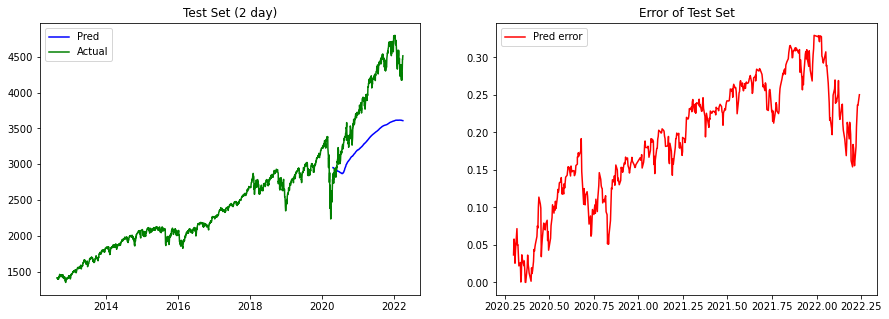

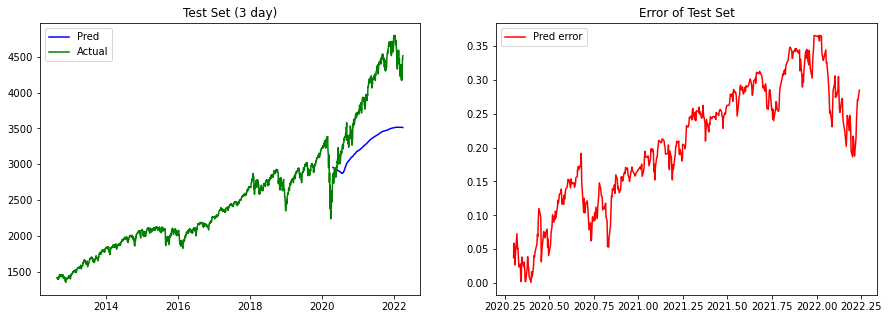

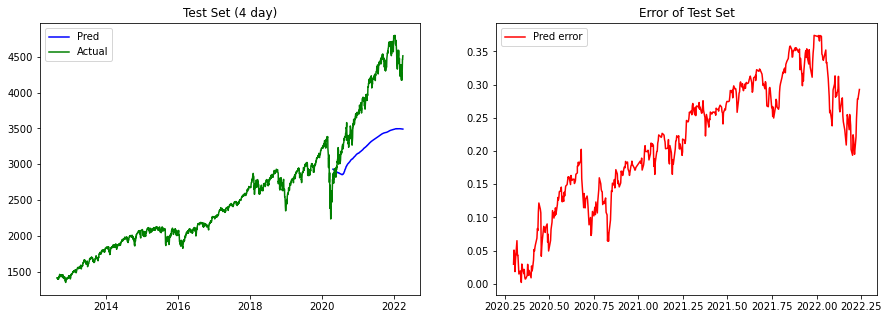

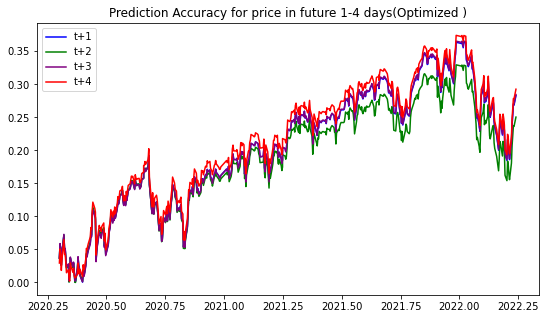

In [23]:
RNN_enhance.eval()
xTensor = torch.from_numpy(X_test).float()
output, _ = RNN_enhance(xTensor)

Y_plt = norm.inverse_transform(Y[:, :, 0])

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])
import pdb
#pdb.set_trace()
plotGraphs(output_plt1,output_plt2,output_plt3,output_plt4,Y_testplt,Y_plt,dateAxis,date_t,
"Test Set (1 day)","Test Set (2 day)","Test Set (3 day)","Test Set (4 day)","Error of Test Set")

plotAccuracy(output_plt1,output_plt2,output_plt3,output_plt4,Y_testplt,date_t,'Prediction Accuracy for price in future 1-4 days(Optimized )' )

# Step 7 - Enhance your CNN+RNN algorithm's functionality 

(1956, 100, 4)
1278.04
2724.5223834110175
2.131797426849721
494
1278.04
2721.3719357997
4.539305256673379
501
1278.04
2728.0923999799165
9.689559146755602
508
3054.060675726563
3191.0315382298063
10.124123949005828
1360
3057.417227387219
3210.081441075807
10.629645867347865
1367
3057.417227387219
3235.3954348499174
11.248418241784496
1374
3057.417227387219
3249.9478529049966
11.956749764475319
1381
3008.6515371419487
3008.6515371419487
11.956749764475319
1630


Text(0, 0.5, 'Money (in millions)')

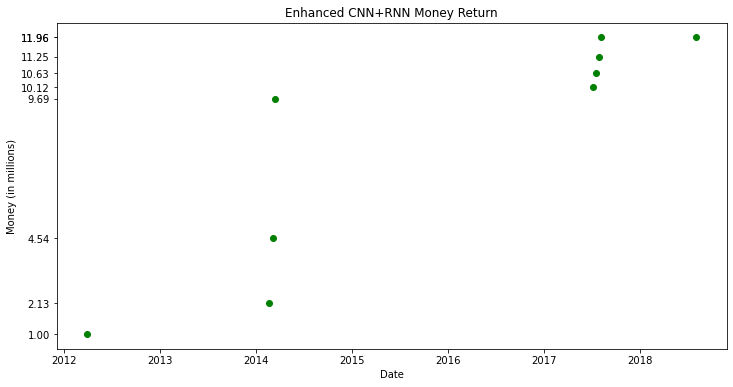

In [24]:
print(X_fullTraining.shape)
# start with $1 m 
money = 1
money_all = []
trade_all = []
date_all = []
money_all.append(money)
date_all.append(dateDigital[0])
sampleNum = 6
# Must buy the new stock before sell
lastsell = -sampleNum

for i in range(1,X_fullTraining.shape[0]):
    tmp = norm.inverse_transform(X_fullTraining[i,:, :])
    
    prob_temp = tmp[:, 2]
    price_temp = tmp[:, 0]
    
    # Sell when has high prob
    if dataset[i][2] > 0.9 and (i-lastsell > sampleNum):
        
        
        # The buy at a low PE ration
        
        buy_price = min(price_temp)
        
        if buy_price > 0:
            sell_price = price_temp[len(price_temp)-1]
            
            money*= (sell_price/buy_price)
            
            lastsell = i
            money_all.append(money)
            trade_all.append(i)
            date_all.append(dateDigital[i])
            
            print(buy_price)
            print(sell_price)
            print(money)
            print(i)
plt.figure(figsize=(12, 6));
plt.scatter(date_all,
         money_all, color='green', label='Close')
plt.yticks(money_all)
plt.title('Enhanced CNN+RNN Money Return')
plt.xlabel('Date')
plt.ylabel('Money (in millions)')

# Step 8 - Determine the Effect of Input Data Perturbations(Price Uncertainty) on your Algorithm

## 8a) Using your Optimized CNN+RNN algorithm (from Step 6, above) corrupt your Test Set that you used in Step 5

In [25]:
def add_noisy(dataset, threshold):
    dataset_noise = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set random seed 
    random.seed(2)
    cut_nums = 4
    for i in range(len(dataset)):
        
        s = np.random.normal(0, threshold, cut_nums)
        idx = random.sample(list(range(window_size)), cut_nums)
        dataset_noise[i] = dataset[i] 
        
        #scale the s by the sampling window
        s = max(X_test[1, idx, 0])*s
        tmp = dataset_noise[i, idx, 0] + s
        # modify the data when negative
        tmp[tmp < 0] = 1e-7
        dataset_noise[i, idx, 0]  = tmp
        
    return dataset_noise   

## 8b) Repeat Tests in Step 6, above, with noise-corrupted Test Set.

In [26]:
# For the next 1 day: idx=0 

std = [0, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1 ]

idx = 0
out_tmp = np.concatenate( (Y_test[:, :, idx], Y_test[:, :, idx], Y_test[:, :, idx]), axis = 1)
target_test = norm.inverse_transform(out_tmp)[:, [0]]
error_res_all = []

for threshold in std:
    print(threshold)
    dataset_test_noise = add_noisy(X_test, threshold)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = RNN_enhance(test_inputs)
    out_tmp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                               output_test.detach().numpy()[:, [idx]],  
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    
    predicted_price_test = norm.inverse_transform(out_tmp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))


0
0.001
0.005
0.01
0.02
0.05
0.1


In [27]:
print(X_fullTraining.shape)
print(X_training.shape)
print(X_validation.shape)
print(X_test.shape)

(1956, 100, 4)
(1564, 100, 4)
(392, 100, 4)
(490, 100, 4)


## 8c) Repeat Step 7, above, to Determine How Much Money You Make or Lose

0
0.001
0.005
0.01
0.02
0.05
0.1


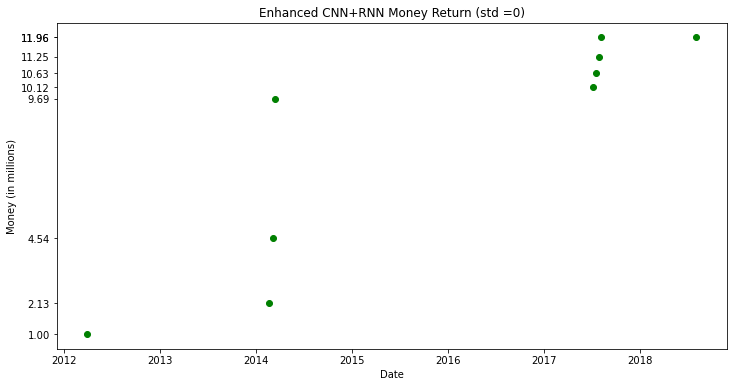

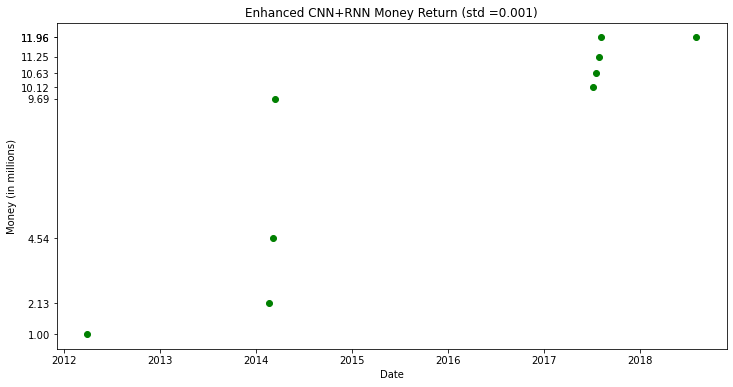

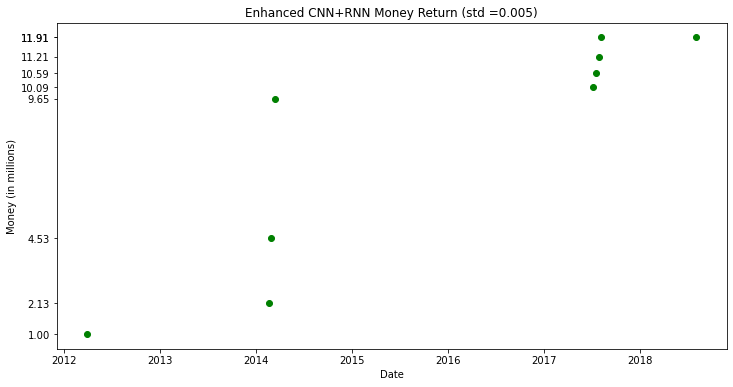

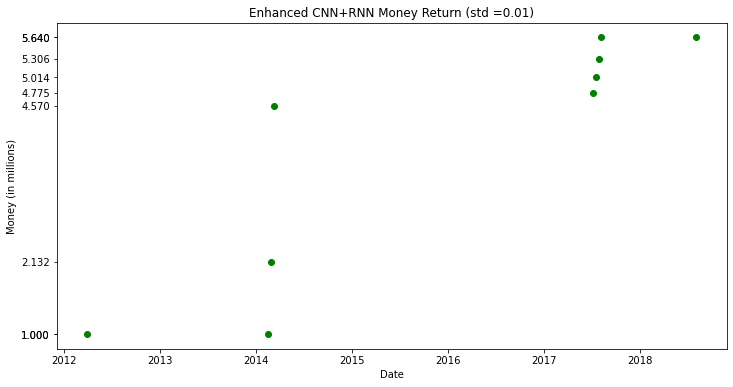

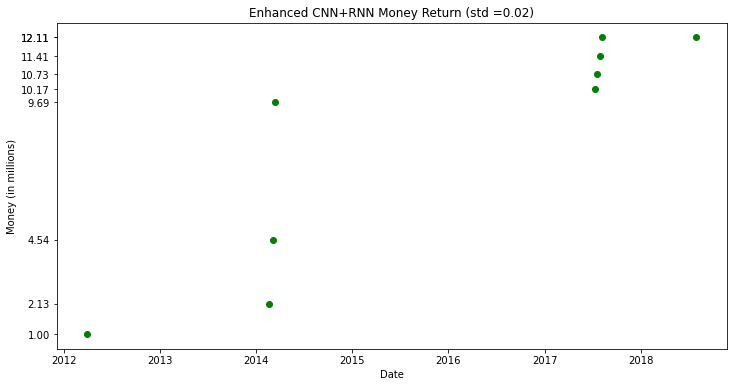

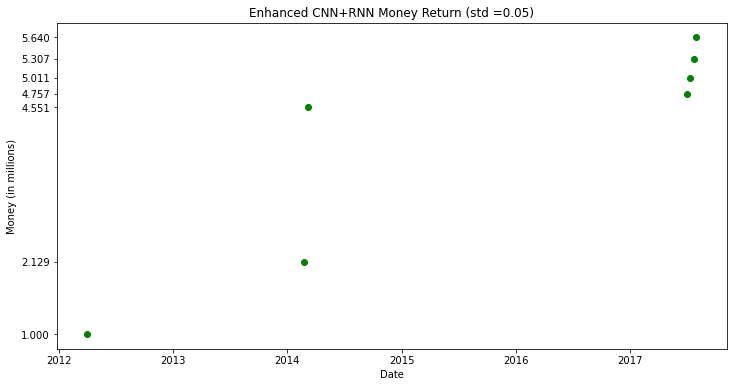

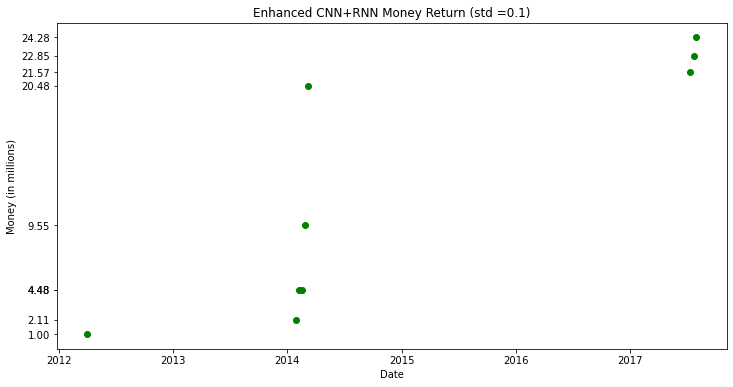

In [28]:
def add_noise1D(outputVector,stdev):
    mean = 0
    noise = np.random.normal(mean,stdev,outputVector.shape)
    return outputVector + noise

for threshold in std:
    # Redoing step 2 in order to add noise to ratio_sp, and thus dataset (which is used in step 7)
    print(threshold)
    ratio_sp_noise = add_noise1D(ratio_sp, threshold)
    
    record_noise = []
    recordDate_noise = []
    
    for i in range(len(date_sp)):
        tmp = [0 for _ in range(3)]
        tmp[0] = sp_index[i][0]
        record_time = str(date_sp[i][0])
        for j in range(len(ratio_sp)):
            peDate = get_date( array_date_pe[j][0] )

            if(peDate is not None and len(peDate)==3) :
                if(record_time[6:10]==peDate[2] ):
                        if(peDate[1]==record_time[0:2] or ('0'+peDate[1])==record_time[0:2]):
                            tmp[1] = ratio_sp_noise[j]
                            recordDate_noise.append(record_time)
                            record_noise.append(tmp)
    
    dataset_noise = np.array(record_noise)
    sampleNum = 100
    for i in range(sampleNum-1 ,len(dataset)):
        # Pearson  r
        x = dataset_noise[(i-sampleNum+1):(i+1), 0]
        y = dataset_noise[(i-sampleNum+1):(i+1), 1]
        r = np.corrcoef(x, y)
        dataset_noise[i][2] = r[0,1] # Here is where we create noisy data used for step 8c

    # start with $1 m 
    money = 1
    money_all = []
    trade_all = []
    date_all = []
    money_all.append(money)
    date_all.append(dateDigital[0])
    sampleNum = 6
    # Must buy the new stock before sell
    lastsell = -sampleNum

    for i in range(1,X_fullTraining.shape[0]):
        tmp = norm.inverse_transform(X_fullTraining[i,:, :])

        prob_temp = tmp[:, 2]
        price_temp = tmp[:, 0]

        # Sell when has high prob
        if dataset_noise[i][2] > 0.9 and (i-lastsell > sampleNum): # Just repeating step 7, but using dataset_noise


            # The buy at a low PE ration

            buy_price = min(price_temp)

            if buy_price > 0:
                sell_price = price_temp[len(price_temp)-1]

                money*= (sell_price/buy_price)

                lastsell = i
                money_all.append(money)
                trade_all.append(i)
                date_all.append(dateDigital[i])
    
    plt.figure(figsize=(12, 6));
    plt.scatter(date_all,
             money_all, color='green', label='Close')
    plt.yticks(money_all)
    plt.title('Enhanced CNN+RNN Money Return (std =' + str(threshold) + ')')
    plt.xlabel('Date')
    plt.ylabel('Money (in millions)')
    plt.plot()

In [29]:
print(X_fullTraining.shape)
# start with $1 m 
money = 1
money_all = []
trade_all = []
sampleNum = 6
# Must buy the new stock before sell
lastsell = -sampleNum

for i in range(1,test_inputs.shape[0]):
    tmp = norm.inverse_transform(test_inputs[i,:, :])
    
    prob_temp = tmp[:, 2]
    price_temp = tmp[:, 0]
    
    # Sell when has high prob
    if dataset[i][2] > 0.9 and (i-lastsell > sampleNum):
        
        
        # The buy at a low PE ration
        
        buy_price = min(price_temp)
        
        if buy_price > 0:
            sell_price = price_temp[len(price_temp)-1]
            
            money*= (sell_price/buy_price)
            
            lastsell = i
            money_all.append(money)
            trade_all.append(i)
            
            print(buy_price)
            print(sell_price)
            print(money)
            print(i)   

(1956, 100, 4)


In [30]:
# test_img = []
# for i in range(X_test.shape[0]):  
#     x = X_test[i,:, 0]
#     # make plot for the sp500 price data    
#     plt.axis('off')
#     plt.plot(x, color ="grey") 
    
#     fig = plt.gcf()
#     fig.set_size_inches(8, 8)
#     fig.canvas.draw()
       
#     width, height = fig.get_size_inches() * fig.get_dpi()
    
#     mplimage = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(576, 576, 3)
    
#     gray_image = color.rgb2gray(mplimage)
#     img_resize = resize(gray_image, (180, 180),anti_aliasing=True)
#     img_resize = img_resize.astype('float32')
#     plt.clf()   
#     # appending the image into the list
#     test_img.append(img_resize)
    
# test_x = np.array(test_img)


In [31]:
# convert image format for torch
#test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1], test_x.shape[2])
# test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1)
# test_x = torch.from_numpy(test_x)
# test_x.shape

In [32]:
# predict sell signal
# with torch.no_grad():
#     test = True
#     output,_ = RNN(test_x)

# prob = torch.nn.functional.softmax(output, dim=1)
# '''
# if  prob > 0.5
#       sell
#  else:
#       keep
# '''

In [33]:
money_res_all = []
trade_res_all = []
# sd = [0.001]
# standard deviation
sd = [0.0, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
for sigma in sd:
    print(sigma)
    dataset_test_noise = add_noisy(X_test, sigma)
    # loading images of the test dataset
    test_img = []
    for i in range(dataset_test_noise.shape[0]):  
        x = dataset_test_noise[i,:, 0]
        # function to plot the sp500 price data    
        plt.axis('off')
        plt.plot(x, color ="black") 
        figure = plt.gcf()
        figure.set_size_inches(8, 8)
        figure.canvas.draw()

        width, height = figure.get_size_inches() * figure.get_dpi()
        mplimage = np.frombuffer(figure.canvas.tostring_rgb(), dtype='uint8').reshape(576, 576, 3)
        gray_image = color.rgb2gray(mplimage)
        img_resize = resize(gray_image, (180, 180),anti_aliasing=True)
        img_resize = img_resize.astype('float32')
        plt.clf()   
        # appending the image into the list
        test_img.append(img_resize)

    # converting the list to numpy array
    test_x = np.array(test_img)
    
    # converting images into torch format
    test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1], test_x.shape[2])
    test_x = torch.from_numpy(test_x)
    
    
    # predict sell signal for whole dataset
    with torch.no_grad():
        output = RNN(test_x)

    softmax = torch.exp(output)
    # if prob > 0.5 then sell signal
    # otherwise, hold 
    prob = softmax.numpy()[:,1]/np.sum(softmax.numpy(), axis = 1) 
    
    # assuming you start with $1 million.
    money = 1
    money_full = []
    trade_full = []
    # if you haven't sell the stock, you cannot buy the new stock, in that case buypower = 0
    lastselltime = 0
    for i in range(1, X_test.shape[0]):
        temp = norm.inverse_transform(X_test[i,:, :])
        prob_temp = prob[i]
        price_temp = temp[:, 0]
        date_diff = date_test[i,0] - date_test[lastselltime,0]
        days = date_diff.astype('timedelta64[D]')
        days_diff = days / np.timedelta64(1, 'D')
        if prob_temp > 0.9 and (days_diff > sampleNum):
            # sell at this point
            # buy at the local minia in this window interval
            buy_price = min(price_temp)
            # in case of the overflow
            if buy_price > 0:              
                sell_price = price_temp[len(price_temp)-1]
                money = sell_price/buy_price*money
                lastselltime = i
                print(money)
                print(i)   
                money_full.append(money)
                trade_full.append(i)
                
            
    money_res_all.append(money_full)
    trade_res_all.append(trade_full)

0.0


RuntimeError: number of dims don't match in permute

<Figure size 576x576 with 0 Axes>

In [ ]:
cmaps= ['red','orange',  'yellow', 'green','blue', 'purple', 'pink', 'grey', 'brown', 'black' ]
plt.figure(1, figsize=(12, 6))
for i in range(len(std)):   
    plt.plot(date_test[trade_res_all[i]], money_res_all[i] , color=cmaps[i], lw=1, label = sd[i], marker= 'o')
    
plt.ylabel('Money/millions')
plt.xlabel('Time')

plt.title('Money Earned for CNN+RNN Model with Noise-Corrupted Test Data <2012-2020> (Optimized)')
plt.legend(loc="upper left") 

# Step 9 - Modify the CNN+RNN algorithm in this assignment to generate a BUY signal as well as a SELL signal.  Then optimize your enhanced algorithm as stated in Steps 5 and 6. 